# Definimos una clase para el algoritmo genético
### Inputs:
- pop_sz_0: Tamaño de la población inicial (Número de individuos que debe contener la población inicial)
- fit_fn: Función de fitness del algoritmo que permite asignar un valor a un individuo sobre la base de que tan bien cumple con el objetivo.
- cr_genes: Función para generar genes
- cr_indv: Función para generar individuos
- mut_rate: Tasa de mutación
- term_cond: Condición de terminación del algoritmo.


In [133]:
class GENALG(object):
    # Método inicializador para la clase algoritmo genético 

    def __init__(self, pop_sz_0: int, fit_fn, cr_genes, cr_indv, indv_chars, term_cond, mut_rate=0.0, elitism_rate=0.0):
        # Verificamos que los parámetros de entrada del constructor sean los correctos
        if type(pop_sz_0) != int:
            raise ValueError("Input n_weights debe ser un número entero positivo")        
        self.__pop_sz = pop_sz_0
        self.__pop = None
        self.__pop_fitness = None
        self.__max_fitness = None
        self.__mean_fitness = None
        self.__min_fitness = None
        self.__fittest_indv = None
        self.__fit_fn = fit_fn
        self.__cr_genes = cr_genes
        self.__cr_indv = cr_indv
        self.__indv_chars = indv_chars
        self.__num_genes = len(list(indv_chars.keys()))        
        self.__term_cond = term_cond
        self.__mut_rate = mut_rate
        self.__elitism = int(np.ceil(elitism_rate*pop_sz_0))

    # Métodos get para obtener los atributos del algoritmo genético.

    # Función para obtener el tamaño de la población
    def get_pop_sz(self):
        return self.__pop_sz
    
    # Función para obtener la población
    def get_pop(self):
        if self.__pop is None:
            raise ValueError("la población no ha sido creada")
        else:
            return self.__pop
    
    # Función para obtener la tasa de mutación
    def get_mut_rate(self):
        return self.__mut_rate
   
    # Función para obtener condición de terminación
    def get_term_cond(self):
        return self.__term_cond    

    # Función para obtener la función de fitness del algoritmo
    def get_fit_fn(self):
        return self.__fit_fn

    # Función para obtener la función de creación de genes del algoritmo
    def get_cr_genes(self):
        return self.__cr_genes
    
    # Función para obtener la función de creación de individuos del algoritmo
    def get_cr_indv(self):
        return self.__cr_indv    
    
    # Función para obtener el número de genes de los individuos del algoritmo
    def get_num_genes(self):
        return self.__num_genes    
           
            
    # Función para generar la población inicial
    def gen_pop(self):
        pop = {}
        for i in range(self.__pop_sz):
            pop[i] = self.__cr_indv(self.__cr_genes, indv_chars)
        self.__pop = pop

    def comp_pop_fitness(self, fit_params):   
        pop_fitness = {} 
        new_pop = {}
        l_pfitness = []
        ranking = {}
        fittest_indv = None
        for i in range(self.__pop_sz):
            fitness = self.__fit_fn(self.__pop[i], fit_params)           
            l_pfitness.append(fitness)        
        mean_fitness = np.mean(l_pfitness)
        max_fitness = max(l_pfitness)
        min_fitness = min(l_pfitness)
        fittest_indv = self.__pop[l_pfitness.index(max_fitness)].copy()
        self.__max_fitness = max_fitness
        self.__min_fitness = min_fitness
        self.__mean_fitness = mean_fitness
        self.__fittest_indv = fittest_indv
        l_aux = l_pfitness[:]
        for i in range(self.__pop_sz):
            max_ind = l_aux.index(max(l_aux))
            new_pop[i] = self.__pop[max_ind].copy()
            pop_fitness[i]= l_aux[max_ind]
            l_aux[max_ind] =-np.inf
        self.__pop = new_pop.copy()
        self.__pop_fitness = pop_fitness.copy()
    
    # Método para aplicar la selección mediante torneo de los individuos de la población. Recibe de entrada el número 
    # de competidores (entero positivo). Asume que la poblacíon está reordenada en base al fitness de manera decreciente 
    # (paso que ocurre al calcular el fitness de la población con el método comp_pop_fitness)
    def tournament_sel(self, slots: int):
        if slots > self.__pop_sz:
            raise ValueError("slots debe ser un número entero positivo menor que el tamaño de la población")
        else:
            chosen_set = np.random.randint(0, self.__pop_sz, slots)            
            winner = min(chosen_set)
            return self.__pop[winner]
    
    # Método para aplicar la selección mediante ruleta de los individuos de la población.
    def roulette_sel(self):
        fit_vals = list(self.__pop_fitness.values())
        num_neg_vals = sum(n < 0 for n in fit_vals)
        # si hay fitness negativos debemos normalizar estos valores conservando las distancias
        if num_neg_vals>0:
            min_val = abs(min(fit_vals))
            new_fit_vals = [min_val +item for item in fit_vals]
        else:
            new_fit_vals = fit_vals[:]               
        total_fit = sum(new_fit_vals)
        # si todas las fitness son iguales a 0 retornamos un individuo al azar
        if total_fit == 0:
            idx = np.random.randint(0,self.__pop_sz)
            return self.__pop[idx]
        else:
            sum_fit = 0
            th = total_fit*np.random.rand()
            for i in range(self.__pop_sz):
                sum_fit += new_fit_vals[i]
                if sum_fit>th:
                    return self.__pop[i]    
            
            
    
    def crossover(self, indv1, indv2):
        vals1 = list(indv1.values())
        vals2 = list(indv2.values())        
        cut = np.random.randint(1, self.__num_genes)
        new_vals = vals1[:cut] + vals2[cut:]
        keys = list(indv1.keys())
        new_ind = dict(zip(keys, new_vals))
        return new_ind
    
    def mutation(self, indv):
        vals = list(indv.values())        
        new_vals = []
        for i in range(self.__num_genes):            
            if np.random.rand() > self.__mut_rate:
                new_vals.append(vals[i])
            else:
                cond = True
                while cond:
                    new_val = self.__cr_genes(self.__indv_chars[i]['gene_type'],self.__indv_chars[i]['fact_range'])
                    if new_val != vals[i]:
                        cond = False
                new_vals.append(new_val)
        keys = list(indv.keys())
        new_ind = dict(zip(keys, new_vals))
        return new_ind

    def apply(self,fit_params, selection_type='tournament', random_state=None, slots=3):
        if type(random_state) == int:
            np.random.seed(random_state)
        self.gen_pop()
        self.comp_pop_fitness(fit_params)
        generations = {}        
        iters = 0
        overall_max_fitness = self.__max_fitness
        overall_fittest_indv = self.__fittest_indv
        generations[iters] = {}
        generations[iters]['max_fitness'] = self.__max_fitness
        generations[iters]['min_fitness'] = self.__min_fitness
        generations[iters]['mean_fitness'] = self.__mean_fitness
        if self.__term_cond['type']== 'iterations':
            goal_cross = 2*self.__term_cond['iters']            
            if self.__max_fitness >= self.__term_cond['fitness_th'] and goal_cross == 2*self.__term_cond['iters']:
                goal_cross = iters
            while iters < self.__term_cond['iters']:
                new_pop = {}
                for i in range(0, self.__elitism):
                    new_pop[i] = self.__pop[i].copy()            
                for i in range(self.__elitism, self.__pop_sz):
                    if selection_type == 'roulette':
                        parent_1 = self.roulette_sel()
                        parent_2 = self.roulette_sel()
                    else:
                        parent_1 = self.tournament_sel(slots)
                        parent_2 = self.tournament_sel(slots)
                    child = self.crossover(parent_1, parent_2)
                    if mut_rate > 0.0:
                        child = self.mutation(child)
                    new_pop[i] = child
                self.__pop = new_pop.copy()
                self.comp_pop_fitness(fit_params)
                iters += 1
                generations[iters] = {}
                generations[iters]['max_fitness'] = self.__max_fitness
                generations[iters]['min_fitness'] = self.__min_fitness
                generations[iters]['mean_fitness'] = self.__mean_fitness
                if self.__max_fitness > overall_max_fitness:
                    overall_max_fitness = self.__max_fitness
                    overall_fittest_indv = self.__fittest_indv                
                if self.__max_fitness >= self.__term_cond['fitness_th'] and goal_cross == 2*self.__term_cond['iters']:
                    goal_cross = iters
        else:
            while overall_max_fitness < self.__term_cond['fitness_th']:
                new_pop = {}
                for i in range(0, self.__elitism):
                    new_pop[i] = self.__pop[i].copy()            
                for i in range(self.__elitism, self.__pop_sz):
                    if selection_type == 'roulette':
                        parent_1 = self.roulette_sel()
                        parent_2 = self.roulette_sel()
                    else:
                        parent_1 = self.tournament_sel(slots)
                        parent_2 = self.tournament_sel(slots)
                    child = self.crossover(parent_1, parent_2)
                    if mut_rate > 0.0:
                        child = self.mutation(child)
                    new_pop[i] = child
                self.__pop = new_pop.copy()
                self.comp_pop_fitness(fit_params)
                iters += 1
                generations[iters] = {}
                generations[iters]['max_fitness'] = self.__max_fitness
                generations[iters]['min_fitness'] = self.__min_fitness
                generations[iters]['mean_fitness'] = self.__mean_fitness
                if self.__max_fitness > overall_max_fitness:
                    overall_max_fitness = self.__max_fitness
                    overall_fittest_indv = self.__fittest_indv
                if self.__term_cond['iters']< iters:
                    break
            if overall_max_fitness >= self.__term_cond['fitness_th']:
                goal_cross = iters
            else:
                goal_cross = 2*self.__term_cond['iters']            
        return generations, goal_cross, overall_max_fitness, overall_fittest_indv
    
    

In [162]:
def gene_factory_ex1(gene_type, fact_range):
    if fact_range != [0,1] or gene_type != 'binary':
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.choice(fact_range)
        return gene

def indv_factory(gene_factory, indv_chars):    
    vals = list(indv_chars.values())
    num_genes = len(vals)
    new_indv = {}
    for i in range(num_genes):
        new_indv[i] = gene_factory(indv_chars[i]['gene_type'],indv_chars[i]['fact_range'])
    return new_indv

def fitness_ex1(indv, objective):
    vals = list(indv.values())
    vals_str = ''.join(str(i) for i in vals)
    fitness = objective['ponderador']*abs(int(objective['secuencia'], 2)-int(vals_str, 2))
    return -fitness

In [163]:
# Prueba ejercicio 1
secuencia_bits = '00101010110101'
ponderador = 1/(2**(len(secuencia_bits)-4))
fit_params={'secuencia':secuencia_bits, 'ponderador': ponderador}
pop_sz_0 = 50
fit_fn = fitness_ex1 
cr_genes = gene_factory_ex1
cr_indv = indv_factory
mut_rate = 0.1
term_cond = {'type':'iterations','fitness_th':0, 'iters':100} 
selection_type='tournament'
slots = 5
elitism_rate = 0.0
random_state = 42
indv_chars = {}
for i in range(len(secuencia_bits)):
    aux_dict = {}
    aux_dict['gene_type'] = 'binary'
    aux_dict['fact_range'] = [0,1]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, indv_chars, term_cond, mut_rate, elitism_rate )
generations, goal_cross, overall_max_fitness, overall_fittest_indv=GA.apply(fit_params, selection_type, random_state, slots)

In [164]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

In [165]:
goal_cross

11

In [166]:
2**10

1024

In [167]:
max_fit

[-0.162109375,
 -0.05859375,
 -0.052734375,
 -0.0546875,
 -0.041015625,
 -0.0400390625,
 -0.033203125,
 -0.0078125,
 -0.001953125,
 -0.0009765625,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0009765625,
 -0.0,
 -0.0009765625,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0009765625,
 -0.0009765625,
 -0.0009765625,
 -0.0009765625,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0009765625,
 -0.0009765625,
 -0.0,
 -0.0,
 -0.0,
 -0.0,
 -0.0]

In [168]:
min_fit

[-13.03125,
 -13.1220703125,
 -9.66015625,
 -8.1572265625,
 -8.4150390625,
 -4.1875,
 -8.291015625,
 -8.0556640625,
 -12.0498046875,
 -8.509765625,
 -8.287109375,
 -12.001953125,
 -9.1171875,
 -4.25,
 -11.9384765625,
 -11.9990234375,
 -8.1982421875,
 -8.009765625,
 -8.998046875,
 -11.9990234375,
 -8.001953125,
 -8.0068359375,
 -12.0634765625,
 -9.0,
 -11.9521484375,
 -8.0078125,
 -9.0068359375,
 -8.2412109375,
 -13.0,
 -13.2958984375,
 -8.0634765625,
 -6.0009765625,
 -9.25,
 -8.3125,
 -7.9990234375,
 -8.2509765625,
 -8.8125,
 -9.0068359375,
 -11.9384765625,
 -9.00390625,
 -11.9970703125,
 -8.259765625,
 -12.009765625,
 -9.0009765625,
 -9.0,
 -7.875,
 -8.0078125,
 -8.984375,
 -12.25,
 -9.314453125,
 -8.984375,
 -11.8759765625,
 -8.8544921875,
 -8.044921875,
 -7.83984375,
 -8.0,
 -9.0,
 -8.25,
 -9.25,
 -8.0625,
 -11.984375,
 -10.21875,
 -8.96875,
 -7.9609375,
 -12.2509765625,
 -9.0625,
 -8.0,
 -12.0068359375,
 -11.875,
 -11.9990234375,
 -8.0263671875,
 -8.0078125,
 -8.0693359375,
 -8.747

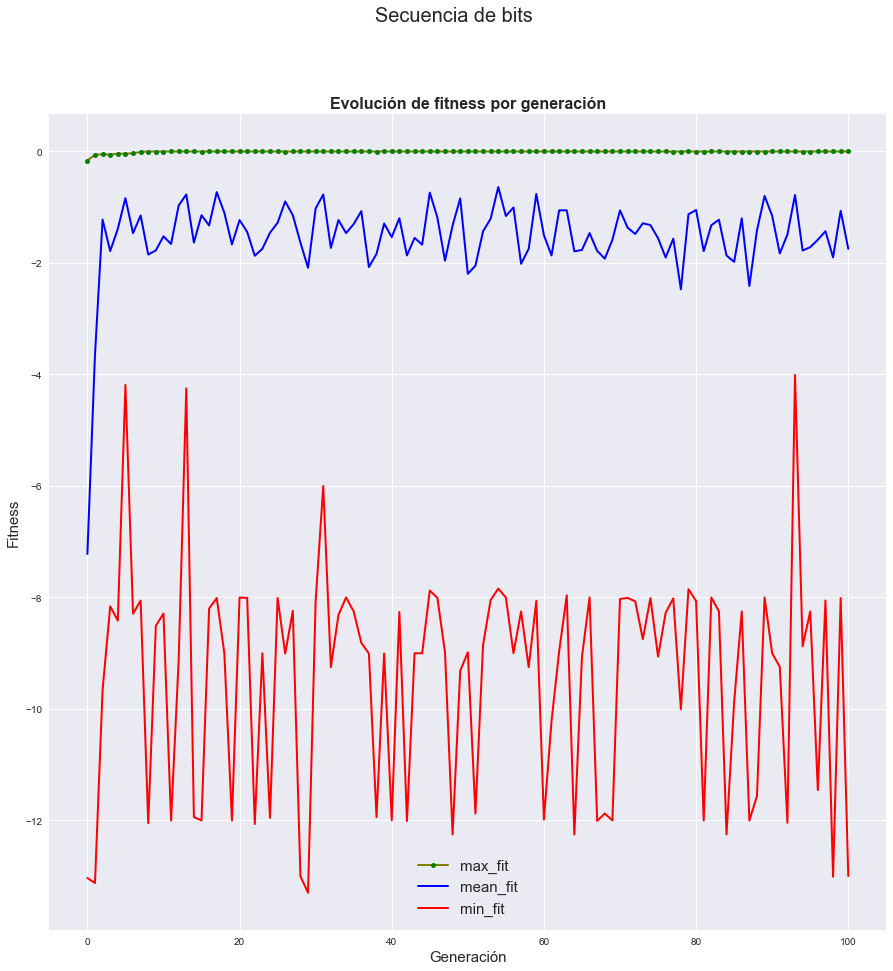

In [171]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='green', markersize=5, color='olive', linewidth=2,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='blue', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='red', linewidth=2, label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
plt.suptitle("Secuencia de bits", fontsize=20)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images\Fitness_por_Generacion_EX1.png')
plt.show()

In [175]:
# Prueba ejercicio 1 elitismo
secuencia_bits = '00101010110101'
ponderador = 1/(2**(len(secuencia_bits)-4))
fit_params={'secuencia':secuencia_bits, 'ponderador': ponderador}
pop_sz_0 = 50
fit_fn = fitness_ex1 
cr_genes = gene_factory_ex1
cr_indv = indv_factory
mut_rate = 0.1
term_cond = {'type':'iterations','fitness_th':0, 'iters':100} 
selection_type='tournament'
slots = 5
elitism_rate = 0.2
random_state = 42
indv_chars = {}
for i in range(len(secuencia_bits)):
    aux_dict = {}
    aux_dict['gene_type'] = 'binary'
    aux_dict['fact_range'] = [0,1]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, indv_chars, term_cond, mut_rate, elitism_rate )
generations, goal_cross, overall_max_fitness, overall_fittest_indv=GA.apply(fit_params, selection_type, random_state, slots)

In [176]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

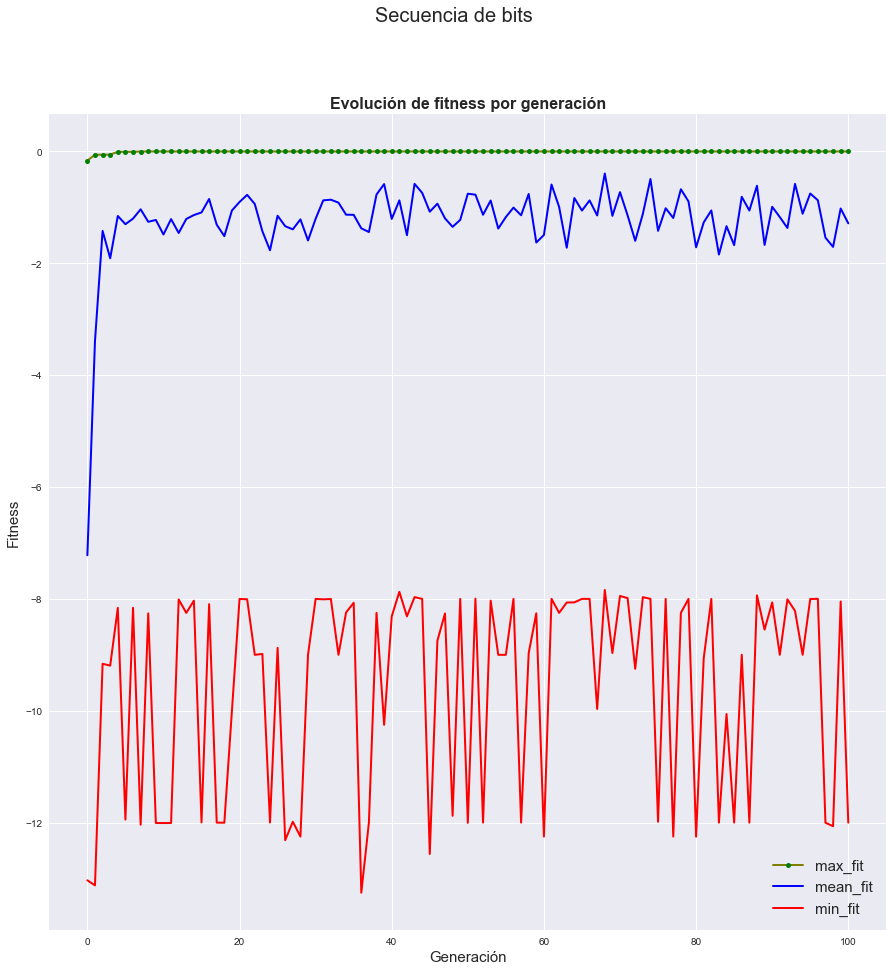

In [177]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='green', markersize=5, color='olive', linewidth=2,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='blue', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='red', linewidth=2, label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
plt.suptitle("Secuencia de bits", fontsize=20)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images\Fitness_por_Generacion_EX1_Elitismo.png')
plt.show()

## Ejercicio 2

In [178]:
def gene_factory_ex2(gene_type, fact_range):
    if fact_range != list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ') or gene_type != str:
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.choice(fact_range)
        return gene

def indv_factory(gene_factory, indv_chars):    
    vals = list(indv_chars.values())
    num_genes = len(vals)
    new_indv = {}
    for i in range(num_genes):
        new_indv[i] = gene_factory(indv_chars[i]['gene_type'],indv_chars[i]['fact_range'])
    return new_indv

def fitness_ex2(indv, objective):
    vals = list(indv.values())
    obj = list(objective)
    hits =0
    for i in range(len(vals)):
        if vals[i] == obj[i]:
            hits += 1   
    return hits

In [179]:
# Prueba ejercicio 2
random_state = 42
frase = 'helloworld'
pop_sz_0 = 50
fit_fn = fitness_ex2 
cr_genes = gene_factory_ex2
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'type':'iterations','fitness_th':10, 'iters':100} 
indv_chars = {}
selection_type='tournament'
slots = 5
elitism_rate = 0.0
char_list = list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ')
for i in range(len(frase)):
    aux_dict = {}
    aux_dict['gene_type'] = str
    aux_dict['fact_range'] = char_list
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, indv_chars,term_cond, mut_rate, elitism_rate)
generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(frase,selection_type, random_state, slots)

In [180]:
overall_fittest_indv

{0: 'h',
 1: 'e',
 2: 'l',
 3: 'l',
 4: 'o',
 5: 'w',
 6: 'o',
 7: 'r',
 8: 'l',
 9: 'd'}

In [181]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

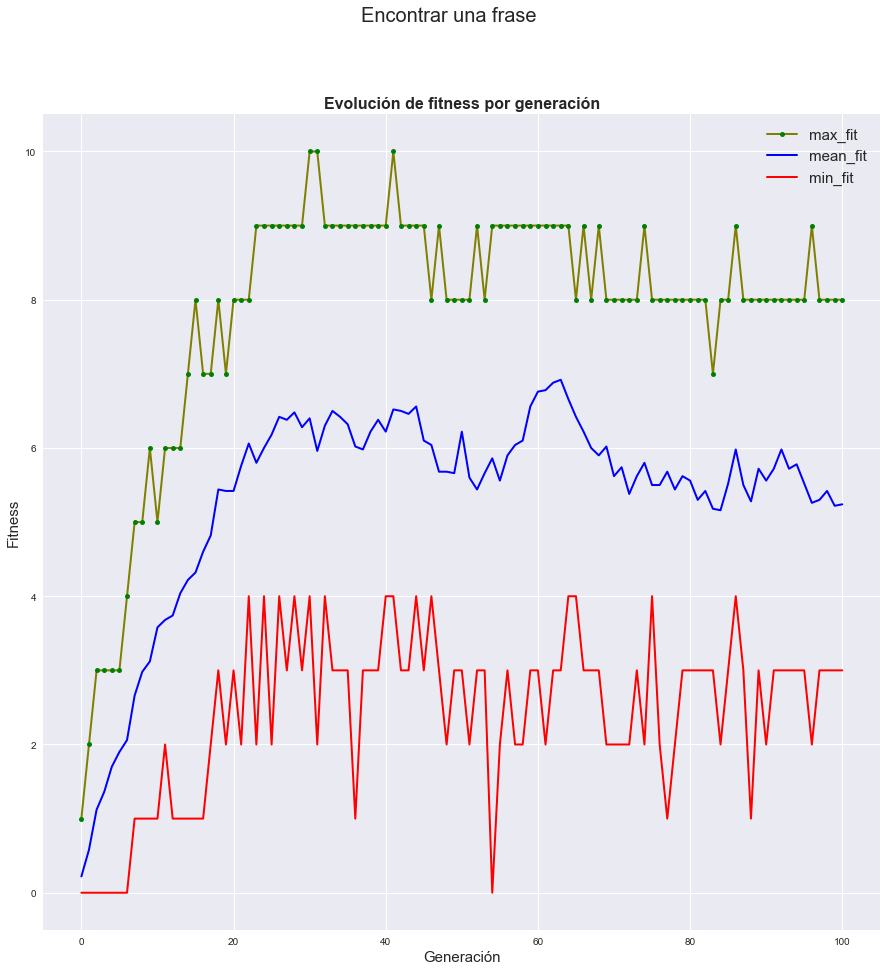

In [182]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='green', markersize=5, color='olive', linewidth=2,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='blue', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='red', linewidth=2, label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
plt.suptitle("Encontrar una frase", fontsize=20)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images\Fitness_por_Generacion_EX2.png')
plt.show()

In [183]:
# Prueba ejercicio 2 elitismo
random_state = 42
frase = 'helloworld'
pop_sz_0 = 50
fit_fn = fitness_ex2 
cr_genes = gene_factory_ex2
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'type':'iterations','fitness_th':10, 'iters':100} 
indv_chars = {}
selection_type='tournament'
slots = 5
elitism_rate = 0.2
char_list = list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ')
for i in range(len(frase)):
    aux_dict = {}
    aux_dict['gene_type'] = str
    aux_dict['fact_range'] = char_list
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, indv_chars,term_cond, mut_rate, elitism_rate)
generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(frase,selection_type, random_state, slots)

In [184]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

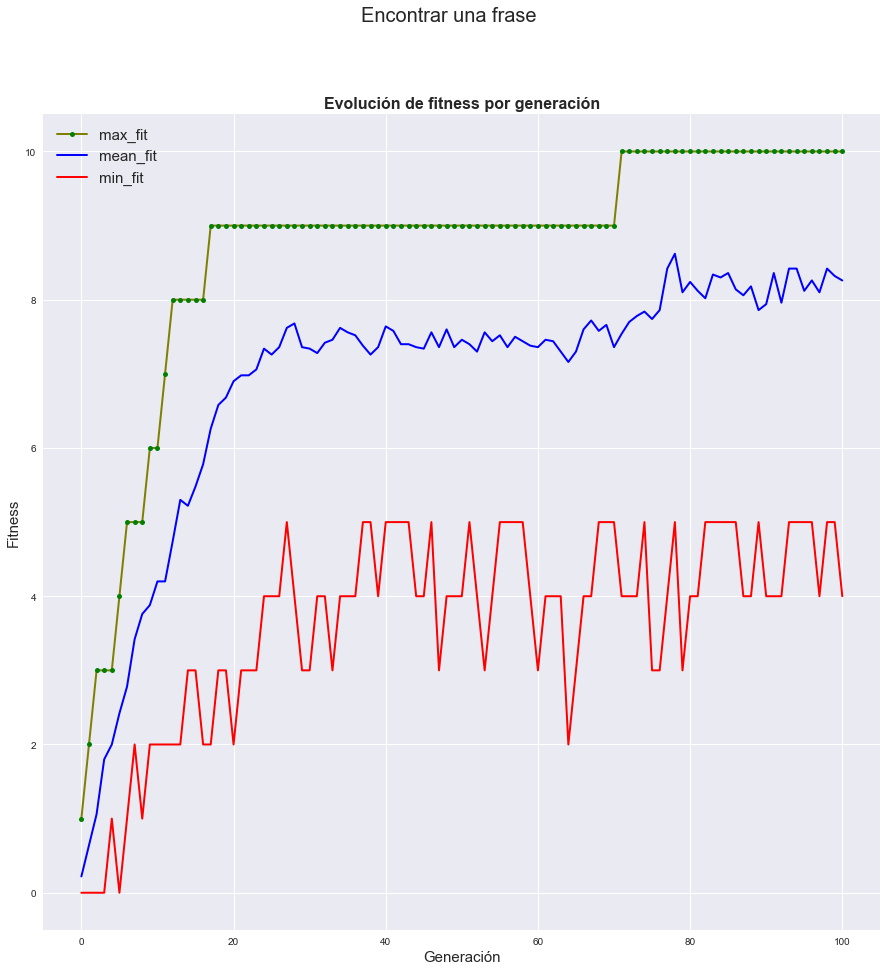

In [185]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='green', markersize=5, color='olive', linewidth=2,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='blue', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='red', linewidth=2, label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
plt.suptitle("Encontrar una frase", fontsize=20)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend(fontsize=15)
plt.savefig('Images\Fitness_por_Generacion_EX2_Elitismo.png')
plt.show()

In [ ]:
random_state = 42
frase = 'helloworld'
fit_fn = fitness_ex2 
cr_genes = gene_factory_ex2
cr_indv = indv_factory
term_cond = {'type':'fitness_th','fitness_th':10, 'iters':100} 
indv_chars = {}
selection_type='tournament'
slots = 5
elitism_rate = 0.0
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [i/10 for i in range(11)]
char_list = list('abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ ')
for i in range(len(frase)):
    aux_dict = {}
    aux_dict['gene_type'] = str
    aux_dict['fact_range'] = char_list
    indv_chars[i] = aux_dict.copy()
res=[]
for rt in mut_rates:    
    mut_rate = rt
    res_rt = []
    for item in pop_sizes:
        pop_sz_0 = item
        GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, indv_chars,term_cond, mut_rate, elitism_rate)
        generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(frase,selection_type, random_state, slots)
        res_rt.append(goal_cross)
    res.append(res_rt[:])



In [ ]:
sns.set()
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(data, annot=True, fmt="d",linewidths=.5, xticklabels =pop_sizes, yticklabels=mut_rates)
plt.title("Heatmap de configuraciones", fontsize=16, fontweight='bold')
plt.xlabel("Tamaño de Población", fontsize=15)
plt.ylabel("Tasa de Mutación", fontsize=15)
plt.savefig('Images\Heatmap.png')
plt.show()

# Ejercicio 3

In [8]:
def gene_factory_ex3(gene_type, fact_range):
    if fact_range != [0,15] or gene_type != int:
        raise ValueError("Parámetros incorrectos")
    else:
        gene = np.random.randint(fact_range[0], fact_range[1]+1)
        return gene
def indv_factory(gene_factory, indv_chars):    
    vals = list(indv_chars.values())
    num_genes = len(vals)
    new_indv = {}
    for i in range(num_genes):
        new_indv[i] = gene_factory(indv_chars[i]['gene_type'],indv_chars[i]['fact_range'])
    return new_indv    
def fitness_ex3(indv, objective):    
    vals = list(indv.values())
    pesos = objective['pesos']
    valores = objective['valores']
    fitness = np.dot(vals,valores)
    penalizacion = 0 
    peso_total = np.dot(vals,pesos)
    if peso_total > objective['capacidad']:
        penalizacion = objective['castigo']*(peso_total - objective['capacidad']) 
    fitness -= penalizacion
    return fitness

In [36]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 15
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sz_0 = 40
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'max_fitness':10, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
slots=5
GA.apply(fit_params, slots)

({0: {'max_fitness': -523, 'mean_fitness': -1845.45, 'min_fitness': -3380},
  1: {'max_fitness': -161, 'mean_fitness': -1165.25, 'min_fitness': -3276},
  2: {'max_fitness': -161, 'mean_fitness': -805.225, 'min_fitness': -2163},
  3: {'max_fitness': 23, 'mean_fitness': -757.525, 'min_fitness': -2742},
  4: {'max_fitness': 13, 'mean_fitness': -445.45, 'min_fitness': -2618},
  5: {'max_fitness': 31, 'mean_fitness': -389.225, 'min_fitness': -2243},
  6: {'max_fitness': 33, 'mean_fitness': -301.725, 'min_fitness': -2063},
  7: {'max_fitness': 33, 'mean_fitness': -303.125, 'min_fitness': -2751},
  8: {'max_fitness': 33, 'mean_fitness': -366.85, 'min_fitness': -2513},
  9: {'max_fitness': 33, 'mean_fitness': -369.075, 'min_fitness': -2023},
  10: {'max_fitness': 31, 'mean_fitness': -353.075, 'min_fitness': -2537},
  11: {'max_fitness': 31, 'mean_fitness': -289.2, 'min_fitness': -2179},
  12: {'max_fitness': 31, 'mean_fitness': -171.475, 'min_fitness': -703},
  13: {'max_fitness': 31, 'mean_fi

In [37]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sz_0 = 40
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
mut_rate = 0.2
term_cond = {'max_fitness':10, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
slots=5
generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)

In [38]:
x = list(generations.keys())
vals = list(generations.values())
max_fit = [item['max_fitness'] for item in vals]
mean_fit = [item['mean_fitness'] for item in vals]
min_fit = [item['min_fitness'] for item in vals]

In [39]:
import matplotlib.pyplot as plt

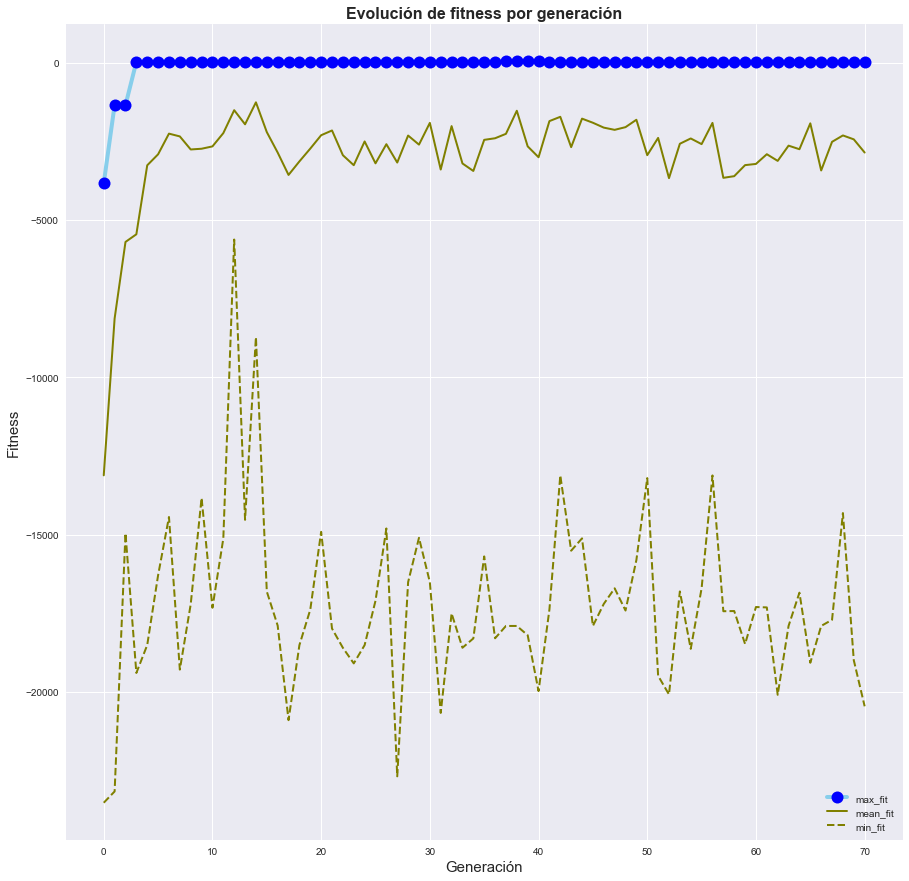

In [99]:
fig= plt.figure(figsize=(15,15))
plt.plot( x,  max_fit, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='max_fit')
plt.plot( x,  mean_fit, marker='', color='olive', linewidth=2,label='mean_fit')
plt.plot( x,  min_fit, marker='', color='olive', linewidth=2, linestyle='dashed', label='min_fit')
plt.title("Evolución de fitness por generación", fontsize=16, fontweight='bold')
#plt.suptitle("Random Walk Suptitle", fontsize=10)
plt.xlabel("Generación", fontsize=15)
plt.ylabel("Fitness", fontsize=15)
plt.legend()
plt.savefig('Images\Fitness_por_Generacion.png')
plt.show()


In [74]:
mut_rates = [i/10 for i in range(11)]
mut_rates

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [62]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [i/10 for i in range(11)]
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
term_cond = {'max_fitness':36, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
res = []
for rt in mut_rates:    
    mut_rate = rt
    res_rt = []
    for item in pop_sizes:
        pop_sz_0 = item
        GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
        slots=5
        generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)
        res_rt.append(goal_cross)
    res.append(res_rt[:])

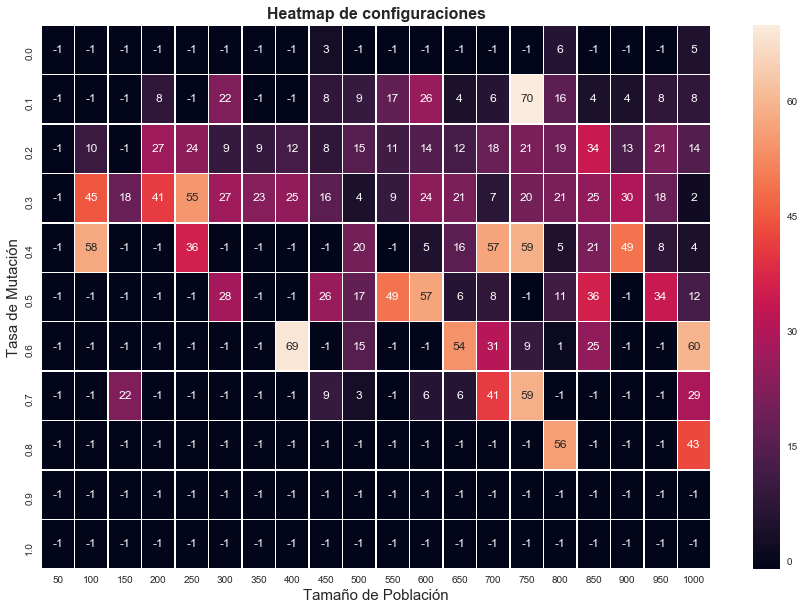

In [97]:
import seaborn as sns
sns.set()
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(data, annot=True, fmt="d",linewidths=.5, xticklabels =pop_sizes, yticklabels=mut_rates)
plt.title("Heatmap de configuraciones", fontsize=16, fontweight='bold')
plt.xlabel("Tamaño de Población", fontsize=15)
plt.ylabel("Tasa de Mutación", fontsize=15)
plt.savefig('Images\Heatmap.png')
plt.show()

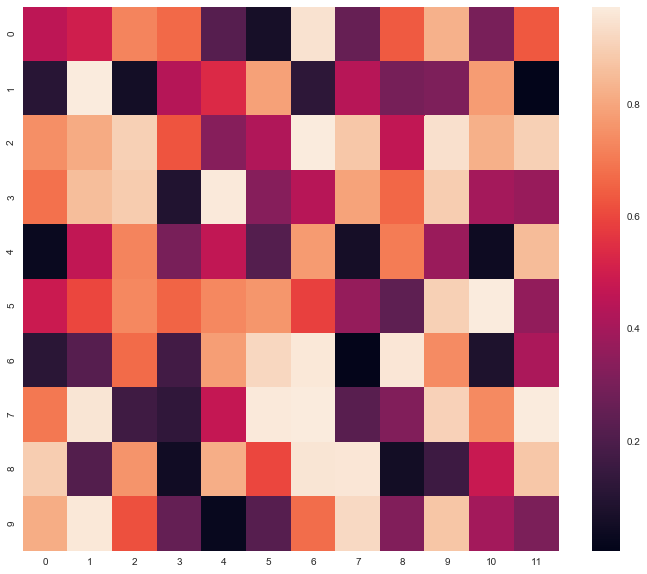

In [55]:

uniform_data = np.random.rand(10, 12)
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(uniform_data)
plt.show()

In [63]:
data = np.array(res)

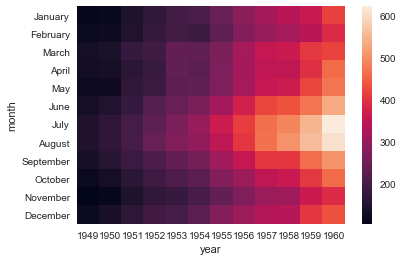

In [68]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)
plt.show()

In [69]:
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
January,112,115,145,171,196,204,242,284,315,340,360,417
February,118,126,150,180,196,188,233,277,301,318,342,391
March,132,141,178,193,236,235,267,317,356,362,406,419
April,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
June,135,149,178,218,243,264,315,374,422,435,472,535
July,148,170,199,230,264,302,364,413,465,491,548,622
August,148,170,199,242,272,293,347,405,467,505,559,606
September,136,158,184,209,237,259,312,355,404,404,463,508


In [57]:
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [0.1* i for i in range(11)]

In [60]:
pop_sizes[-1]

1000

In [ ]:
def gene_factory(gene_type, fact_range=None):
    if type(fact_range) is not list:
            raise ValueError("Debe entregar una lista con el rango de valores factible")
    else:
        if gene_type == int: 
            new_gene = np.random.randint(fact_range[0], fact_range[1]+1)
            return new_gene
        elif gene_type == str:
            new_gene = np.random.choice(fact_range)
            return new_gene
        elif gene_type == 'binary':
            new_gene = np.random.choice(fact_range)
            return new_gene
        elif gene_type == float:
            new_gene = np.random.rand() * (fact_range[1] - fact_range[0]) + fact_range[0]
            return new_gene
        
   

In [ ]:
import numpy as np
np.random.seed(0)
def f_1():
    return np.random.rand()

In [ ]:
f_1()

In [ ]:
f_1()

In [23]:
type(1)==int

True

<function bin>

In [ ]:
a = None

In [ ]:
a is None

In [ ]:
np.inf

In [ ]:
3>-np.inf

In [ ]:
np.random.randint(0, 100,5)

In [ ]:
a= {0:10,1:20}

In [ ]:
list(a.values())


In [4]:
import numpy as np

In [ ]:
np.random.rand()

In [1]:
a=[1,2,3,4]
b=[1,2,3,4]

In [6]:
np.dot(a,b)

30

In [ ]:
np.mean(a)

In [3]:
type(a) is list

True

In [6]:
np.random.choice([0,1])

1

In [7]:
np.random.choice([0,1])

1

In [8]:
np.random.choice([0,1])

1

In [9]:
np.random.choice([0,1])

0

In [10]:
np.random.choice([0,1])

1

In [11]:
np.random.choice([0,1])

0

In [19]:
a ='abcdefghijklmnñopqrstuvwxyzABCDEFGHIJKLMNÑOPQRSTUVWXYZ '
b = list(a)


In [20]:
b

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'ñ',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'Ñ',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 ' ']

In [15]:
list(a)

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'ñ',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'Ñ',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [22]:
np.random.choice('cat')

ValueError: a must be 1-dimensional or an integer

In [28]:
a =[0,1,1,0,1,1,1]

In [29]:
b = ''.join(str(i) for i in a)

In [30]:
b

'0110111'

In [31]:
int(b, 2)

55

In [13]:
# Random Maze Generator using Depth-first Search
# http://en.wikipedia.org/wiki/Maze_generation_algorithm
# FB36 - 20130106
import random
from PIL import Image
imgx = 500; imgy = 500
image = Image.new("RGB", (imgx, imgy))
pixels = image.load()
mx = 100; my = 100 # width and height of the maze
maze = [[0 for x in range(mx)] for y in range(my)]
dx = [0, 1, 0, -1]; dy = [-1, 0, 1, 0] # 4 directions to move in the maze
color = [(0, 0, 0), (255, 255, 255)] # RGB colors of the maze
# start the maze from a random cell
cx = int(random.randint(0, mx - 1)); cy = int(random.randint(0, my - 1))
maze[cy][cx] = 1; stack = [(cx, cy, 0)] # stack element: (x, y, direction)

while len(stack) > 0:
    (cx, cy, cd) = stack[-1]
    # to prevent zigzags:
    # if changed direction in the last move then cannot change again
    if len(stack) > 2:
        if cd != stack[-2][2]: dirRange = [cd]
        else: dirRange = range(4)
    else: dirRange = range(4)

    # find a new cell to add
    nlst = [] # list of available neighbors
    for i in dirRange:
        nx = cx + dx[i]; ny = cy + dy[i]
        if nx >= 0 and nx < mx and ny >= 0 and ny < my:
            if maze[ny][nx] == 0:
                ctr = 0 # of occupied neighbors must be 1
                for j in range(4):
                    ex = nx + dx[j]; ey = ny + dy[j]
                    if ex >= 0 and ex < mx and ey >= 0 and ey < my:
                        if maze[ey][ex] == 1: ctr += 1
                if ctr == 1: nlst.append(i)

    # if 1 or more neighbors available then randomly select one and move
    if len(nlst) > 0:
        ir = nlst[random.randint(0, len(nlst) - 1)]
        cx += dx[ir]; cy += dy[ir]; maze[cy][cx] = 1
        stack.append((cx, cy, ir))
    else: stack.pop()

# paint the maze
for ky in range(imgy):
    for kx in range(imgx):
        pixels[int(kx), int(ky)] = color[maze[my * ky / imgy][mx * kx / imgx]]
image.save("Maze_" + str(mx) + "x" + str(my) + ".png", "PNG")

TypeError: list indices must be integers or slices, not float

In [76]:
a = None

In [80]:
a  != None

False

In [117]:
a =[10,13,7,9, 13]


In [118]:
max(a)

13

In [120]:
a.index(max(a))

1

In [121]:
ranking={}
b = a[:]
for i in range(len(a)):
    max_ind = b.index(max(b))
    ranking[i]= max_ind
    b[max_ind] =-np.inf


In [122]:
ranking

{0: 1, 1: 4, 2: 0, 3: 3, 4: 2}

In [92]:
b = sorted(a, reverse=True)

In [93]:
b

[13, 13, 10, 9, 7]

In [94]:
c=[1,2,3,4,5]

In [95]:
b.pop(0)

13

In [ ]:
c.pop

In [96]:
b

[13, 10, 9, 7]

In [101]:
x=0
for i in range(0,x):
    print(i)
for i in range(x,5):
    print('hola')

hola
hola
hola
hola
hola


In [123]:
a

[10, 13, 7, 9, 13]

In [130]:
sum(a)

52

In [129]:
np.ceil(19.2)

20.0

In [128]:
dict_a = {i:a[i] for i in range(len(a))}
dict_a

{0: 10, 1: 13, 2: 7, 3: 9, 4: 13}

In [ ]:
# Prueba ejercicio 3
pesos = [12,2,1,1,4]
valores = [4,2,2,1,10]
capacidad = 15
castigo = 100
fit_params ={'pesos':pesos, 'valores':valores, 'capacidad':capacidad, 'castigo':castigo}
pop_sizes = [50*i for i in range(1,21)]
mut_rates = [i/10 for i in range(11)]
fit_fn = fitness_ex3 
cr_genes = gene_factory_ex3
cr_indv = indv_factory
term_cond = {'max_fitness':36, 'iters':70} 
indv_chars = {}
for i in range(len(pesos)):
    aux_dict = {}
    aux_dict['gene_type'] = int
    aux_dict['fact_range'] = [0,15]
    indv_chars[i] = aux_dict.copy()
res = []
for rt in mut_rates:    
    mut_rate = rt
    res_rt = []
    for item in pop_sizes:
        pop_sz_0 = item
        GA = GENALG(pop_sz_0, fit_fn, cr_genes, cr_indv, mut_rate, term_cond, indv_chars)
        slots=5
        generations, goal_cross, overall_max_fitness, overall_fittest_indv = GA.apply(fit_params, slots)
        res_rt.append(goal_cross)
    res.append(res_rt[:])